In [14]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from textblob import TextBlob
from textblob_nl import PatternTagger, PatternAnalyzer
from matplotlib.ticker import MultipleLocator
from datetime import datetime
from loguru import logger
import matplotlib.dates as mdates
import click
from matplotlib.ticker import MultipleLocator
from statsmodels.nonparametric.smoothers_lowess import lowess
import re

In [15]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-235500.parquet',
 'inputpath': 'your-path-here.csv',
 'datetime_format': '%d/%m/%Y, %H:%M:%S',
 'drop_authors': [],
 'logging': {'logdir': 'logs'}}

In [16]:
# Remove default logger and add console sink
logger.remove()
logger.add(sys.stderr, level="INFO")

# Get log directory from config
log_dir = Path(config["logging"]["logdir"]).resolve()
log_dir.mkdir(parents=True, exist_ok=True)  # ensure folder exists

# Build timestamped logfile path
# timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logfile = log_dir / f"logfile-{timestamp}.log"

logfile = log_dir / f"logfile.log"

# Add file sink
logger.add(
    logfile,
    rotation="10 MB",
    retention="30 days",
    compression="zip",
    level="DEBUG",
    enqueue=True
)

4

In [17]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

In [18]:
df = pd.read_parquet(datafile)
df.columns

Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length'],
      dtype='object')

In [19]:
# search with regaular expressions for keywords 'camera'
keywords = ["camera", "lens", "canon", "nikon", "sony", "fujifilm", "olympus"]

In [20]:
df_camera = df[df['message'].str.contains(r'\bcamera\b', case=False, regex=True, na=False)]
df_camera.count()

timestamp             94
message               94
author                94
has_emoji             94
is_topk               94
message_length        94
has_link              94
timestamp_category    94
hour                  94
day_of_week           94
msg_length            94
dtype: int64

In [21]:
print(df_camera[['timestamp', 'author', 'message']])

                     timestamp            author  \
995  2023-12-01 08:09:42+00:00     silky-lapwing   
1081 2023-12-23 11:37:44+00:00        soft-eland   
1770 2024-05-25 21:02:34+00:00  vivid-rhinoceros   
1772 2024-05-26 07:23:18+00:00     cheerful-mule   
1786 2024-05-27 15:11:44+00:00     cheerful-mule   
...                        ...               ...   
4289 2025-07-08 14:00:22+00:00        zany-trout   
4301 2025-07-08 19:54:56+00:00  vivid-rhinoceros   
4419 2025-08-08 13:56:27+00:00      joyful-okapi   
4421 2025-08-08 14:02:45+00:00     elaborate-jay   
4422 2025-08-08 14:25:37+00:00  vivid-rhinoceros   

                                                message  
995   De bel en camera doet het niet bij ingang 1. K...  
1081           Maar ik zie geen beweging door de camera  
1770  Lekker dan, tijdje terug raam ingeslagen van e...  
1772  Camera's is geen overbodige luxe! Het is het o...  
1786  Het zou geweldig zijn als er eindelijk camera'...  
...                        

In [37]:
display(df_camera[['timestamp', 'author', 'message']])
# Save selected columns to CSV
df_camera[['timestamp', 'author', 'message']].to_csv('camera_messages.csv', index=False, encoding='utf-8')


,timestamp,author,message
995,2023-12-01 08:09:42+00:00,silky-lapwing,De bel en camera doet het niet bij ingang 1. K...
1081,2023-12-23 11:37:44+00:00,soft-eland,Maar ik zie geen beweging door de camera
1770,2024-05-25 21:02:34+00:00,vivid-rhinoceros,"Lekker dan, tijdje terug raam ingeslagen van e..."
1772,2024-05-26 07:23:18+00:00,cheerful-mule,Camera's is geen overbodige luxe! Het is het o...
1786,2024-05-27 15:11:44+00:00,cheerful-mule,Het zou geweldig zijn als er eindelijk camera'...
...,...,...,...
4289,2025-07-08 14:00:22+00:00,zany-trout,Heb de Flats alleen van de buiten kant bekeken...
4301,2025-07-08 19:54:56+00:00,vivid-rhinoceros,Misschien is dit een idee om de entree te mode...
4419,2025-08-08 13:56:27+00:00,joyful-okapi,Prima toch. Kleur valt wel op. Alleen op de ju...
4421,2025-08-08 14:02:45+00:00,elaborate-jay,"Hallo, kan iemand het volgende verduidelijken:..."


In [25]:
# Make sure 'timestamp' is a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [70]:
# # Count occurrences of 'camera' (case-insensitive) across all messages
# camera_count = df['message'].str.count(r'\bcamera\b', flags=re.IGNORECASE).sum()

# print(f"Total occurrences of 'camera': {camera_count}")

# Count occurrences of 'camera' per row
df['camera_count'] = df['message'].str.count(r'\bcamera\b', flags=re.IGNORECASE)
df.columns

Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length', 'camera_count', 'has_camera'],
      dtype='object')

In [30]:
# Aggregate by time (example: daily)
camera_over_time = df.groupby(df['timestamp'].dt.date)['camera_count'].sum()

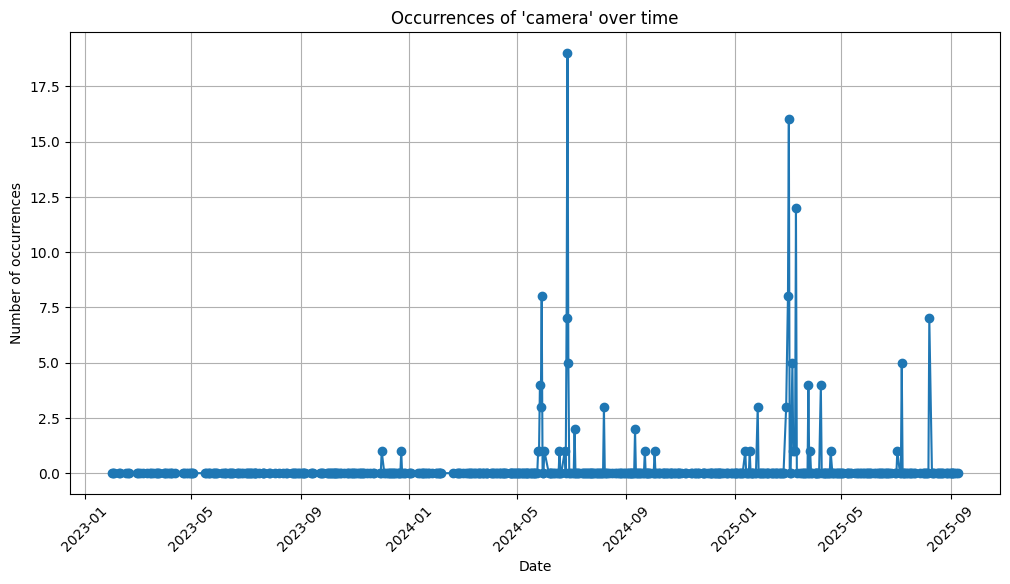

In [31]:
# Plot
plt.figure(figsize=(12,6))
camera_over_time.plot(kind='line', marker='o')
plt.title("Occurrences of 'camera' over time")
plt.xlabel("Date")
plt.ylabel("Number of occurrences")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

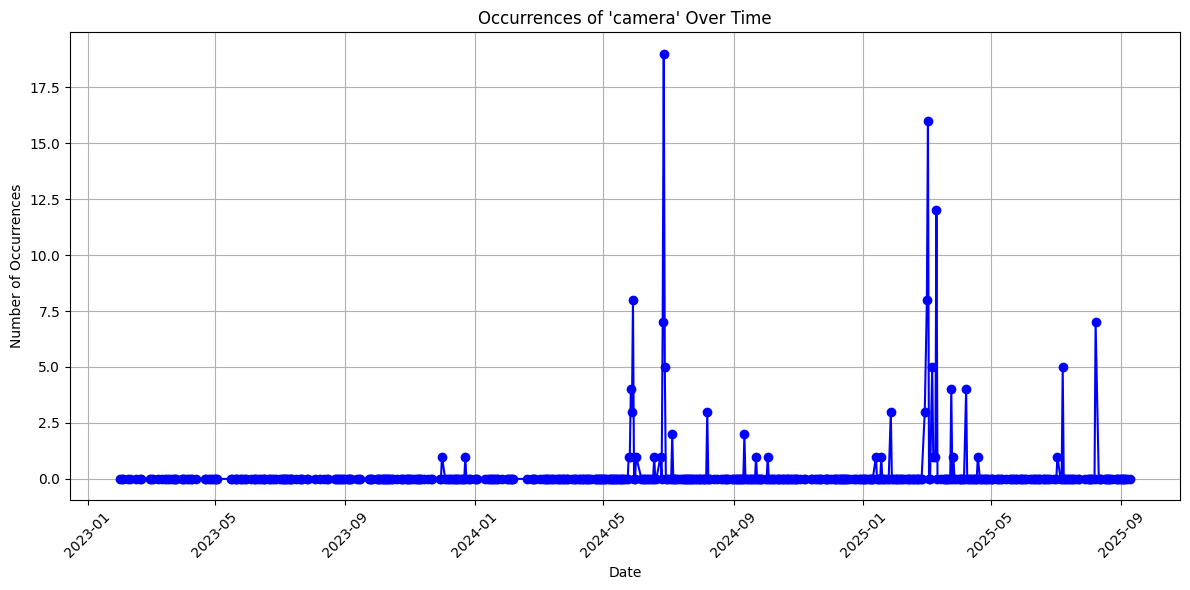

In [32]:
# Plot as a line chart
plt.figure(figsize=(12,6))
plt.plot(camera_over_time.index, camera_over_time.values, marker='o', linestyle='-', color='blue')
plt.title("Occurrences of 'camera' Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_15377/737359885.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['has_camera'] = df_filtered['message'].str.contains(r'\bcamera\b', flags=re.IGNORECASE, regex=True, na=False)
/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_15377/737359885.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  camera_per_month = df_filtered.groupby(df_filtered['timestamp'].dt.to_period('M'))['has_camera'].sum()


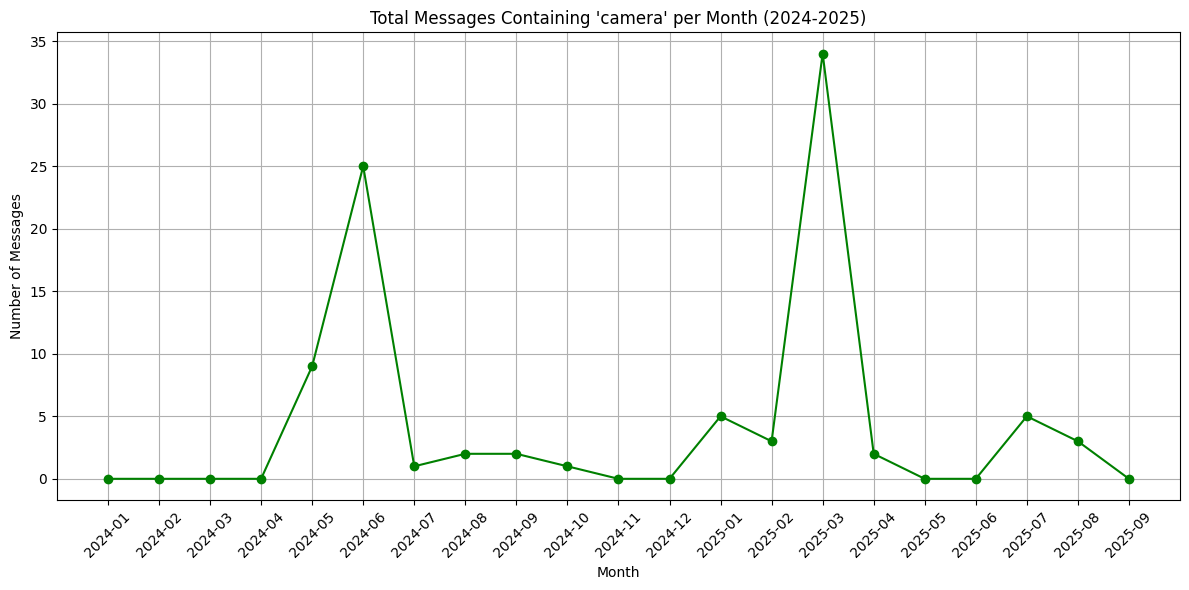

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Ensure 'timestamp' is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter for 2024 and 2025 if needed
df_filtered = df[df['timestamp'].dt.year.isin([2024, 2025])]

# Create a boolean column: does the message contain 'camera'?
df_filtered['has_camera'] = df_filtered['message'].str.contains(r'\bcamera\b', flags=re.IGNORECASE, regex=True, na=False)

# Aggregate by month (count messages containing 'camera')
camera_per_month = df_filtered.groupby(df_filtered['timestamp'].dt.to_period('M'))['has_camera'].sum()

# Convert PeriodIndex to string for plotting
camera_per_month.index = camera_per_month.index.astype(str)

# Plot as a line chart
plt.figure(figsize=(12,6))
plt.plot(camera_per_month.index, camera_per_month.values, marker='o', linestyle='-', color='green')
plt.title("Total Messages Containing 'camera' per Month (2024-2025)")
plt.xlabel("Month")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_15377/2296951908.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  camera_per_month = df.groupby(df['timestamp'].dt.to_period('M'))['has_camera'].sum()


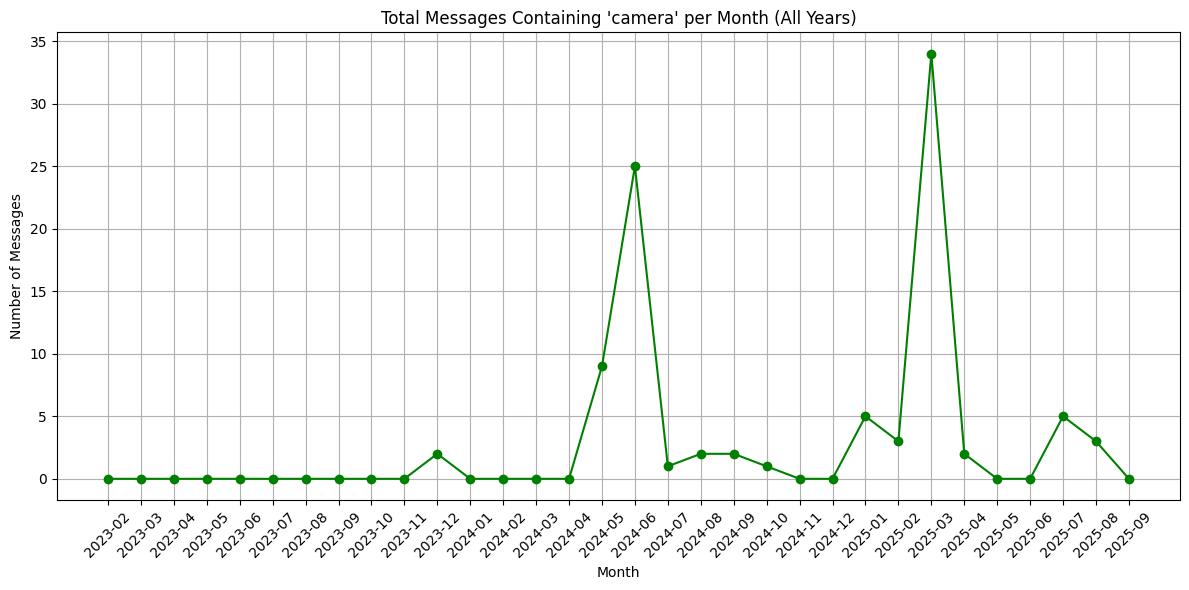

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Ensure 'timestamp' is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a boolean column: does the message contain 'camera'?
df['has_camera'] = df['message'].str.contains(r'\bcamera\b', flags=re.IGNORECASE, regex=True, na=False)

# Aggregate by month (count messages containing 'camera')
camera_per_month = df.groupby(df['timestamp'].dt.to_period('M'))['has_camera'].sum()

# Convert PeriodIndex to string for plotting
camera_per_month.index = camera_per_month.index.astype(str)

# Plot as a line chart
plt.figure(figsize=(12,6))
plt.plot(camera_per_month.index, camera_per_month.values, marker='o', linestyle='-', color='green')
plt.title("Total Messages Containing 'camera' per Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_15377/881610274.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  camera_per_month = df.groupby(df['timestamp'].dt.to_period('M'))['has_camera'].sum()


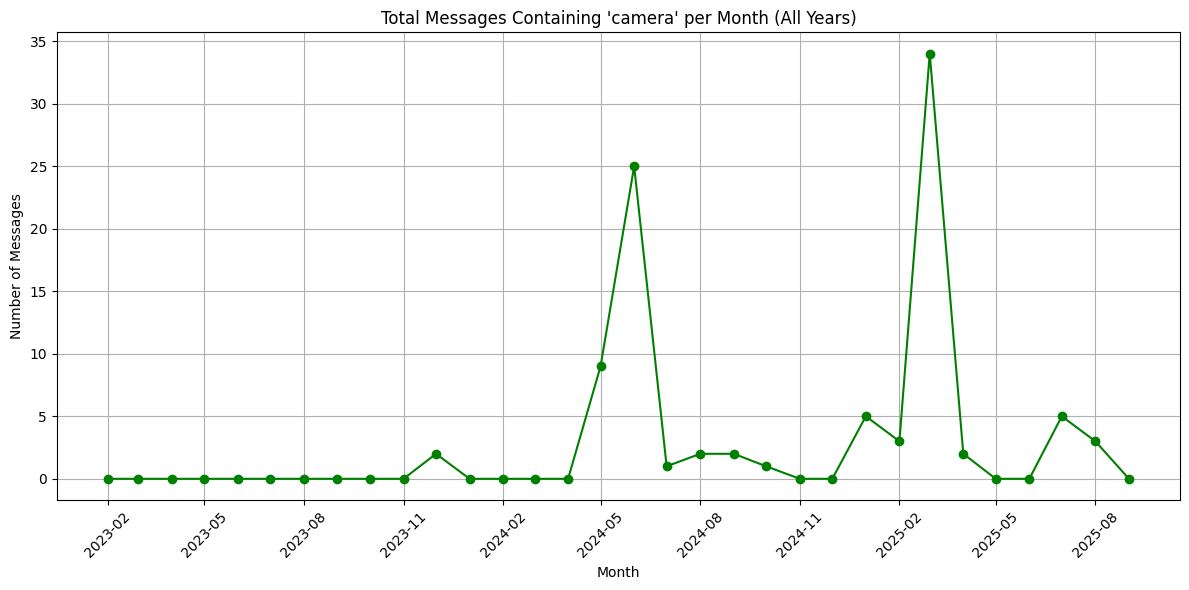

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Ensure 'timestamp' is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a boolean column: does the message contain 'camera'?
df['has_camera'] = df['message'].str.contains(r'\bcamera\b', flags=re.IGNORECASE, regex=True, na=False)

# Aggregate by month (count messages containing 'camera')
camera_per_month = df.groupby(df['timestamp'].dt.to_period('M'))['has_camera'].sum()
camera_per_month.index = camera_per_month.index.to_timestamp()  # Convert PeriodIndex to datetime for plotting

# Plot as a line chart
plt.figure(figsize=(12,6))
plt.plot(camera_per_month.index, camera_per_month.values, marker='o', linestyle='-', color='green')
plt.title("Total Messages Containing 'camera' per Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Number of Messages")
plt.grid(True)

# Set x-axis labels quarterly
plt.xticks(camera_per_month.index[::3], [d.strftime('%Y-%m') for d in camera_per_month.index[::3]], rotation=45)

plt.tight_layout()
plt.show()


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_15377/887279077.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  camera_length_per_month = df_camera.groupby(df_camera['timestamp'].dt.to_period('M'))['message'].apply(lambda x: x.str.len().sum())


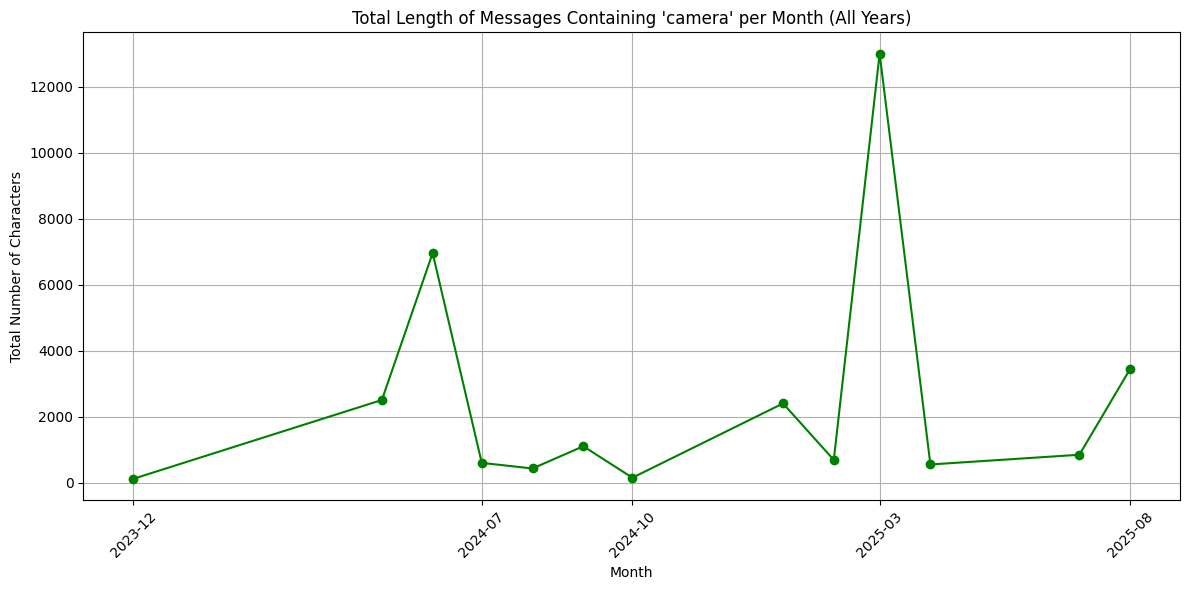

In [41]:
# Filter messages containing 'camera'
df_camera = df[df['has_camera']]

# Aggregate by month: total length of messages
camera_length_per_month = df_camera.groupby(df_camera['timestamp'].dt.to_period('M'))['message'].apply(lambda x: x.str.len().sum())

# Convert PeriodIndex to datetime for plotting
camera_length_per_month.index = camera_length_per_month.index.to_timestamp()

# Plot
plt.figure(figsize=(12,6))
plt.plot(camera_length_per_month.index, camera_length_per_month.values, marker='o', linestyle='-', color='green')
plt.title("Total Length of Messages Containing 'camera' per Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Total Number of Characters")
plt.grid(True)

# Set x-axis labels quarterly
plt.xticks(camera_length_per_month.index[::3], [d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]], rotation=45)

plt.tight_layout()
plt.show()


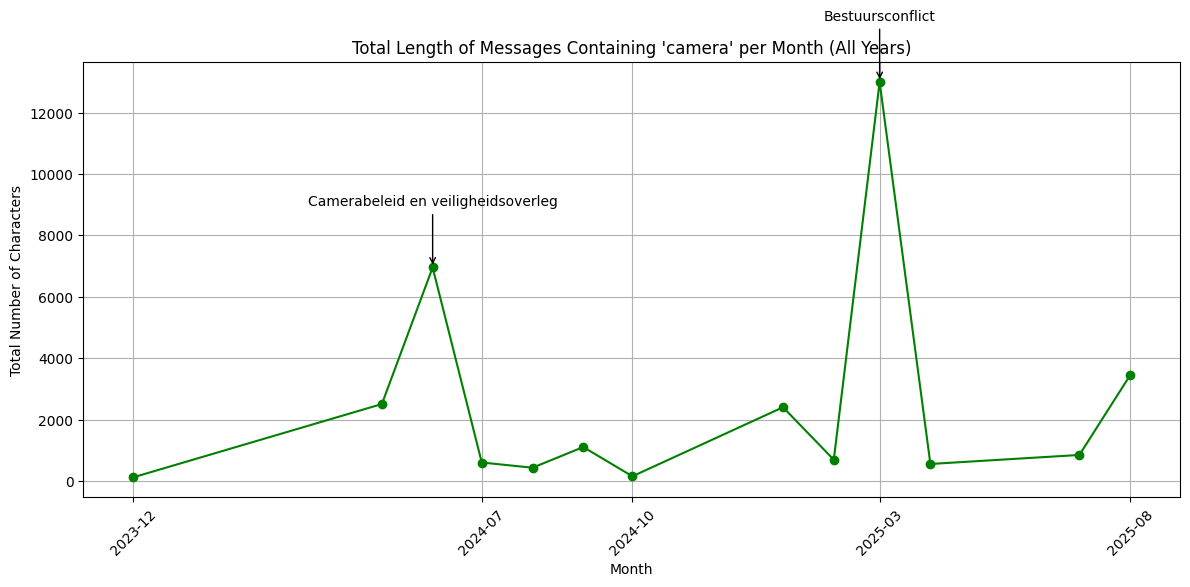

In [42]:
# Find peak 1 (first value > 6000) and peak 2 (first value > 12000)
peak1 = camera_length_per_month[camera_length_per_month > 6000].idxmin()  # earliest index above 6000
peak1_val = camera_length_per_month.loc[peak1]

peak2 = camera_length_per_month[camera_length_per_month > 12000].idxmin()  # earliest index above 12000
peak2_val = camera_length_per_month.loc[peak2]

# Plot
plt.figure(figsize=(12,6))
plt.plot(camera_length_per_month.index, camera_length_per_month.values, marker='o', linestyle='-', color='green')
plt.title("Total Length of Messages Containing 'camera' per Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Total Number of Characters")
plt.grid(True)

# Set x-axis labels every 3 months
plt.xticks(camera_length_per_month.index[::3],
           [d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]],
           rotation=45)

# Add annotations
plt.annotate("Camerabeleid en veiligheidsoverleg",
             xy=(peak1, peak1_val),
             xytext=(peak1, peak1_val + 2000),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             ha='center')

plt.annotate("Bestuursconflict",
             xy=(peak2, peak2_val),
             xytext=(peak2, peak2_val + 2000),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             ha='center')

plt.tight_layout()
plt.show()


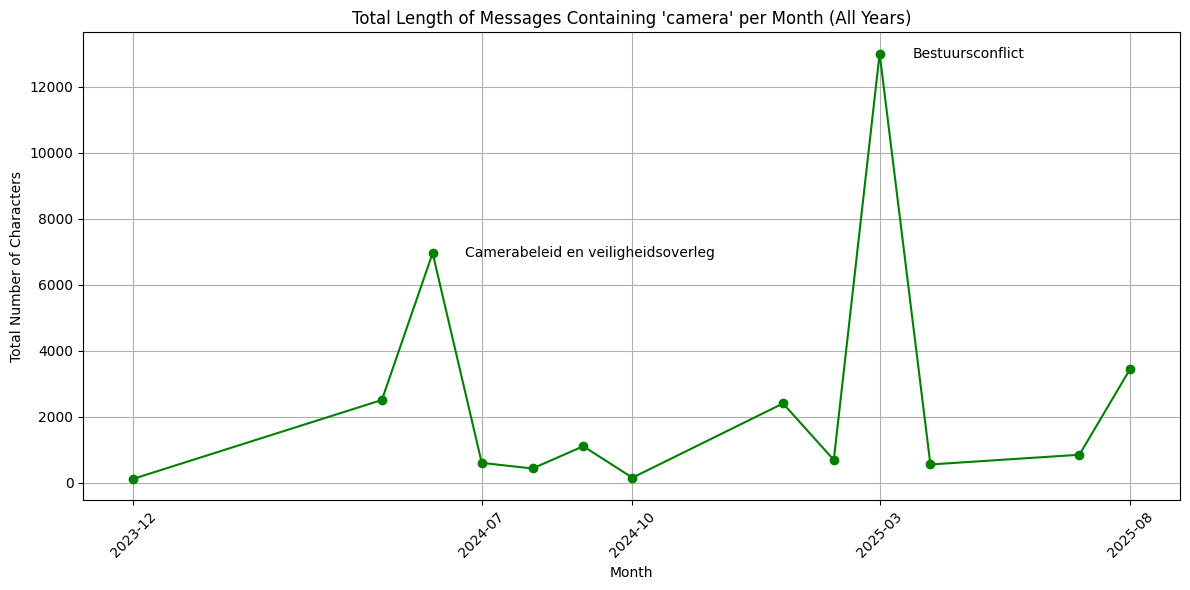

In [43]:
# Find peak 1 (first value > 6000) and peak 2 (first value > 12000)
peak1 = camera_length_per_month[camera_length_per_month > 6000].idxmin()
peak1_val = camera_length_per_month.loc[peak1]

peak2 = camera_length_per_month[camera_length_per_month > 12000].idxmin()
peak2_val = camera_length_per_month.loc[peak2]

# Plot
plt.figure(figsize=(12,6))
plt.plot(camera_length_per_month.index, camera_length_per_month.values, marker='o', linestyle='-', color='green')
plt.title("Total Length of Messages Containing 'camera' per Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Total Number of Characters")
plt.grid(True)

# Set x-axis labels every 3 months
plt.xticks(camera_length_per_month.index[::3],
           [d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]],
           rotation=45)

# Add annotations (side text, no arrow)
plt.annotate("Camerabeleid en veiligheidsoverleg",
             xy=(peak1, peak1_val),
             xytext=(peak1 + pd.DateOffset(days=20), peak1_val),
             ha='left', va='center')

plt.annotate("Bestuursconflict",
             xy=(peak2, peak2_val),
             xytext=(peak2 + pd.DateOffset(days=20), peak2_val),
             ha='left', va='center')

plt.tight_layout()
plt.show()


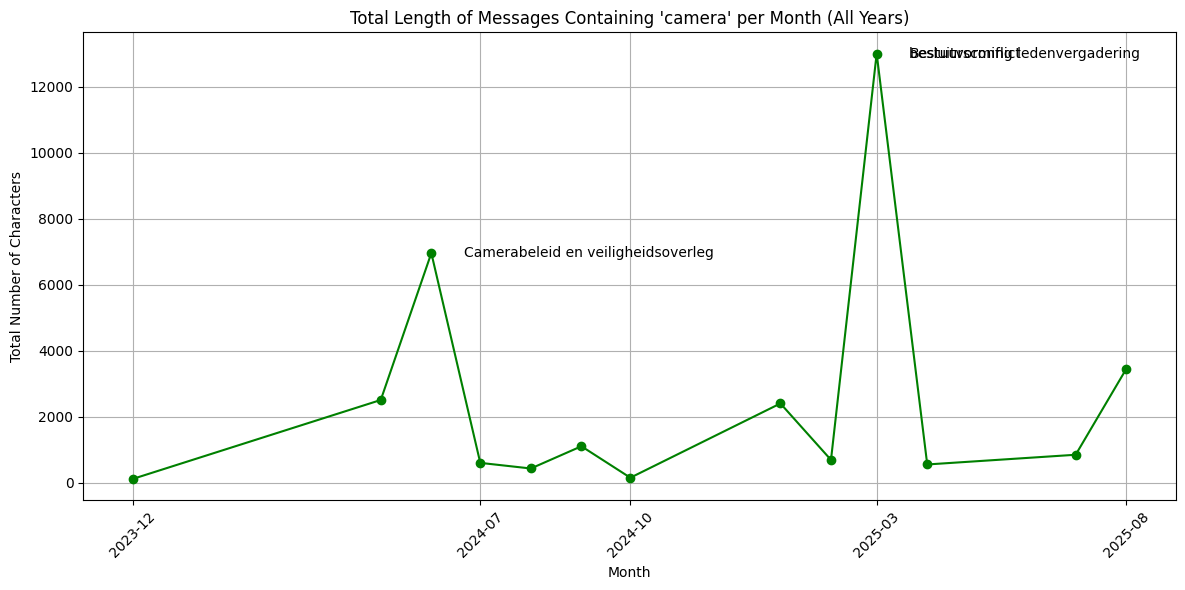

In [44]:
# --- Find peaks ---
# Peak 1: first value > 6000
peak1 = camera_length_per_month[camera_length_per_month > 6000].idxmin()
peak1_val = camera_length_per_month.loc[peak1]

# Peak 2: first value > 12000
peak2 = camera_length_per_month[camera_length_per_month > 12000].idxmin()
peak2_val = camera_length_per_month.loc[peak2]

# Last peak in 2025: max value in 2025
last_peak_idx = camera_length_per_month.loc['2025'].idxmax()
last_peak_val = camera_length_per_month.loc[last_peak_idx]

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(camera_length_per_month.index, camera_length_per_month.values, marker='o', linestyle='-', color='green')
plt.title("Total Length of Messages Containing 'camera' per Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Total Number of Characters")
plt.grid(True)

# Set x-axis labels every 3 months
plt.xticks(camera_length_per_month.index[::3],
           [d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]],
           rotation=45)

# --- Annotations ---
plt.annotate("Camerabeleid en veiligheidsoverleg",
             xy=(peak1, peak1_val),
             xytext=(peak1 + pd.DateOffset(days=20), peak1_val),
             ha='left', va='center')

plt.annotate("Bestuursconflict",
             xy=(peak2, peak2_val),
             xytext=(peak2 + pd.DateOffset(days=20), peak2_val),
             ha='left', va='center')

plt.annotate("besluitvorming ledenvergadering",
             xy=(last_peak_idx, last_peak_val),
             xytext=(last_peak_idx + pd.DateOffset(days=20), last_peak_val),
             ha='left', va='center')

plt.tight_layout()
plt.show()


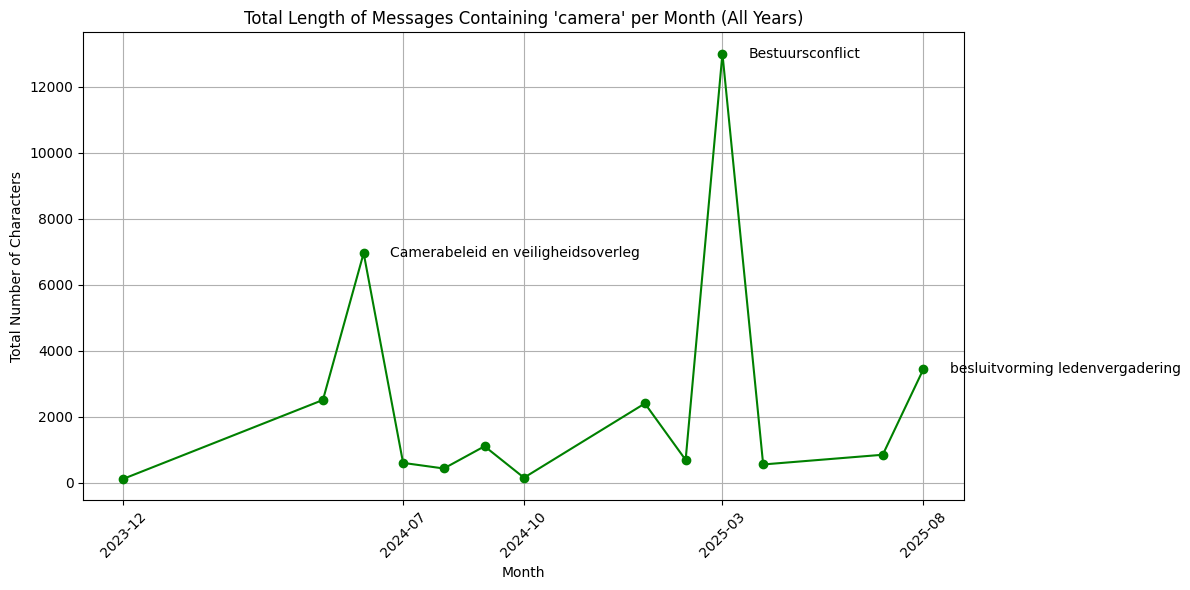

In [45]:
# --- Find peaks ---
# Peak 1: first value > 6000
peak1 = camera_length_per_month[camera_length_per_month > 6000].idxmin()
peak1_val = camera_length_per_month.loc[peak1]

# Peak 2: first value > 12000
peak2 = camera_length_per_month[camera_length_per_month > 12000].idxmin()
peak2_val = camera_length_per_month.loc[peak2]

# Last dot in the plot (final data point)
last_idx = camera_length_per_month.index[-1]
last_val = camera_length_per_month.iloc[-1]

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(camera_length_per_month.index, camera_length_per_month.values, marker='o', linestyle='-', color='green')
plt.title("Total Length of Messages Containing 'camera' per Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Total Number of Characters")
plt.grid(True)

# Set x-axis labels every 3 months
plt.xticks(camera_length_per_month.index[::3],
           [d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]],
           rotation=45)

# --- Annotations ---
plt.annotate("Camerabeleid en veiligheidsoverleg",
             xy=(peak1, peak1_val),
             xytext=(peak1 + pd.DateOffset(days=20), peak1_val),
             ha='left', va='center')

plt.annotate("Bestuursconflict",
             xy=(peak2, peak2_val),
             xytext=(peak2 + pd.DateOffset(days=20), peak2_val),
             ha='left', va='center')

plt.annotate("besluitvorming ledenvergadering",
             xy=(last_idx, last_val),
             xytext=(last_idx + pd.DateOffset(days=20), last_val),
             ha='left', va='center')

plt.tight_layout()
plt.show()



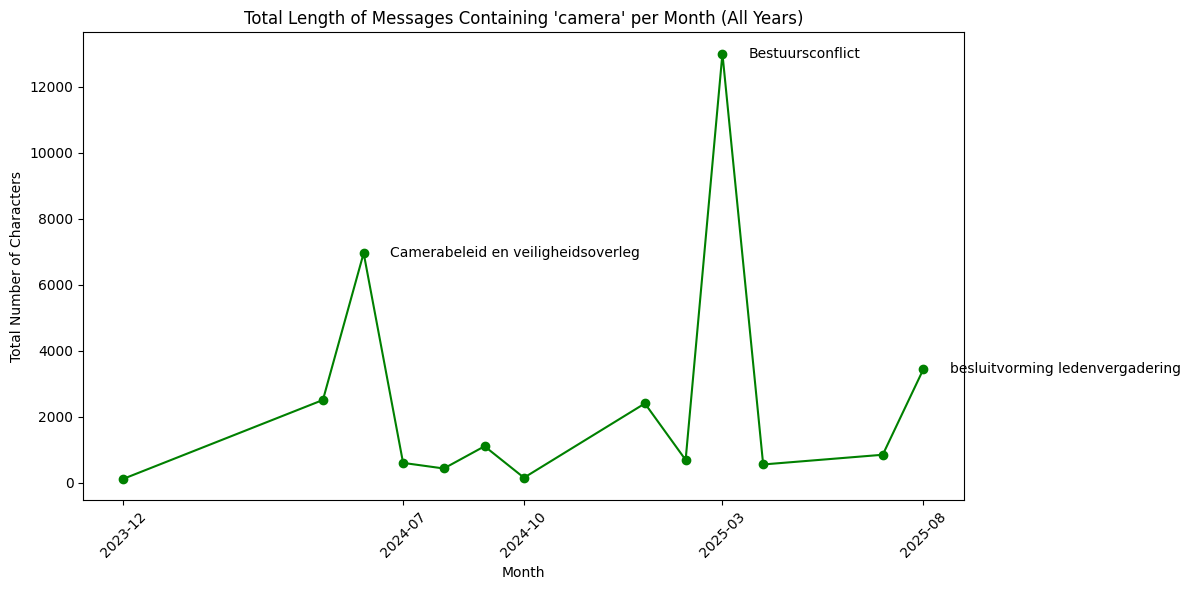

In [46]:
# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(camera_length_per_month.index, camera_length_per_month.values, marker='o', linestyle='-', color='green')
plt.title("Total Length of Messages Containing 'camera' per Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Total Number of Characters")

# Remove grid
plt.grid(False)

# Set x-axis labels every 3 months
plt.xticks(camera_length_per_month.index[::3],
           [d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]],
           rotation=45)

# --- Annotations (same as before) ---
plt.annotate("Camerabeleid en veiligheidsoverleg",
             xy=(peak1, peak1_val),
             xytext=(peak1 + pd.DateOffset(days=20), peak1_val),
             ha='left', va='center')

plt.annotate("Bestuursconflict",
             xy=(peak2, peak2_val),
             xytext=(peak2 + pd.DateOffset(days=20), peak2_val),
             ha='left', va='center')

plt.annotate("besluitvorming ledenvergadering",
             xy=(last_idx, last_val),
             xytext=(last_idx + pd.DateOffset(days=20), last_val),
             ha='left', va='center')

plt.tight_layout()
plt.show()


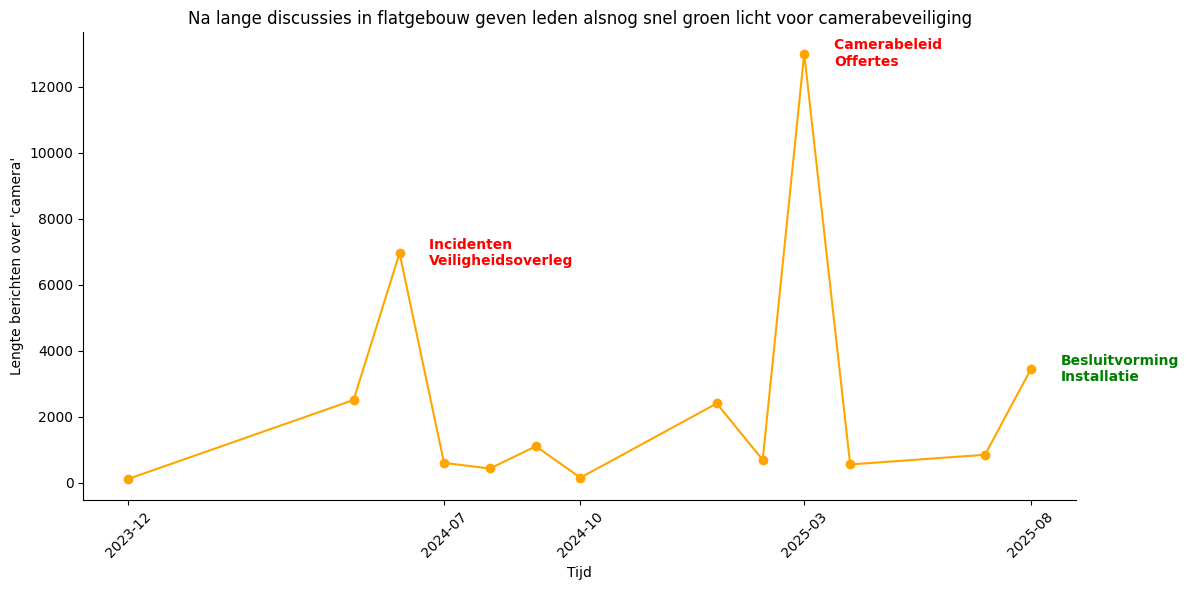

In [69]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(camera_length_per_month.index, camera_length_per_month.values, marker='o', linestyle='-', color='orange')
ax.set_title("Na lange discussies in flatgebouw geven leden alsnog snel groen licht voor camerabeveiliging")
ax.set_xlabel("Tijd")
ax.set_ylabel("Lengte berichten over 'camera'")

# Remove grid
ax.grid(False)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optionally remove left and bottom borders too
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Set x-axis labels every 3 months
ax.set_xticks(camera_length_per_month.index[::3])
ax.set_xticklabels([d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]], rotation=45)

# --- Annotations ---
ax.annotate("Incidenten \nVeiligheidsoverleg",
            xy=(peak1, peak1_val),
            xytext=(peak1 + pd.DateOffset(days=20), peak1_val),
            ha='left', va='center',
            color='red', fontweight='bold')

ax.annotate("Camerabeleid \nOffertes",
            xy=(peak2, peak2_val),
            xytext=(peak2 + pd.DateOffset(days=20), peak2_val),
            ha='left', va='center',
            color='red', fontweight='bold')

ax.annotate("Besluitvorming\nInstallatie",
            xy=(last_idx, last_val),
            xytext=(last_idx + pd.DateOffset(days=20), last_val),
            ha='left', va='center',
            color='green', fontweight='bold')

plt.tight_layout()
plt.show()


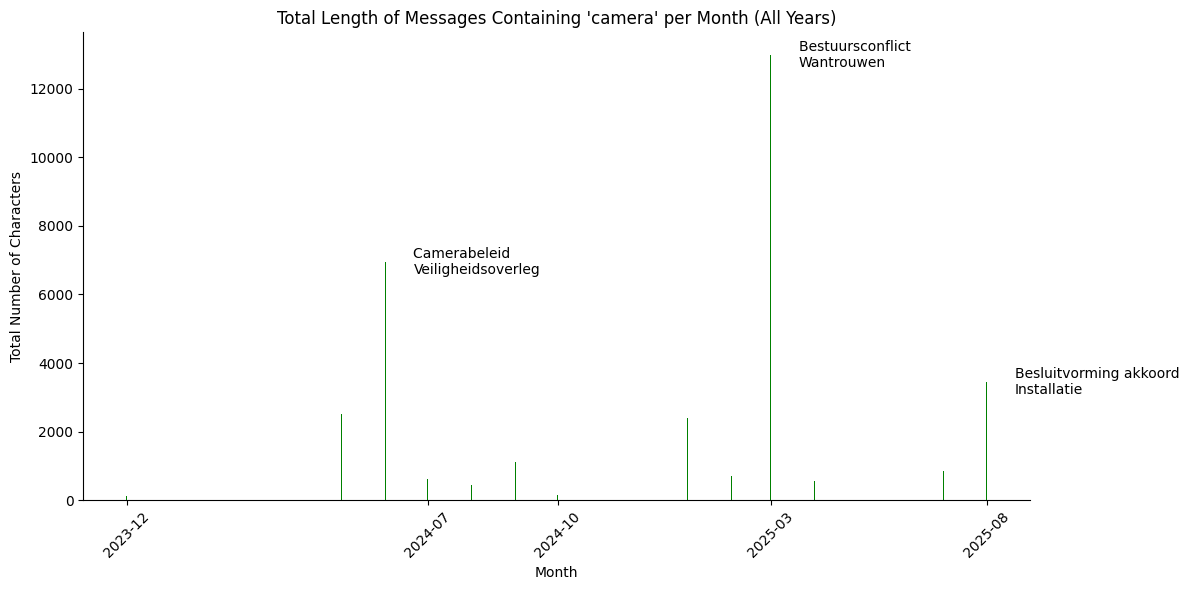

In [51]:
# --- Plot as Bar Plot ---
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(camera_length_per_month.index, camera_length_per_month.values, color='green')
ax.set_title("Total Length of Messages Containing 'camera' per Month (All Years)")
ax.set_xlabel("Month")
ax.set_ylabel("Total Number of Characters")

# Remove grid
ax.grid(False)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x-axis labels every 3 months
ax.set_xticks(camera_length_per_month.index[::3])
ax.set_xticklabels([d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]], rotation=45)

# --- Annotations ---
ax.annotate("Camerabeleid \nVeiligheidsoverleg",
            xy=(peak1, peak1_val),
            xytext=(peak1 + pd.DateOffset(days=20), peak1_val),
            ha='left', va='center')

ax.annotate("Bestuursconflict \nWantrouwen",
            xy=(peak2, peak2_val),
            xytext=(peak2 + pd.DateOffset(days=20), peak2_val),
            ha='left', va='center')

ax.annotate("Besluitvorming akkoord\nInstallatie",
            xy=(last_idx, last_val),
            xytext=(last_idx + pd.DateOffset(days=20), last_val),
            ha='left', va='center')

plt.tight_layout()
plt.show()


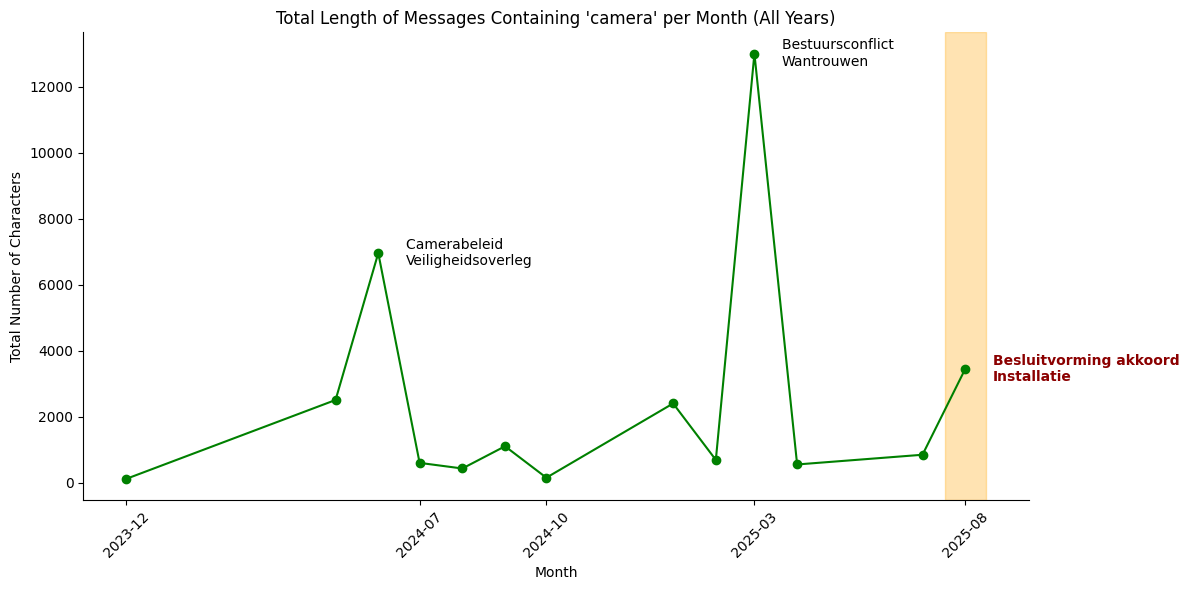

In [52]:
# --- Plot ---
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(camera_length_per_month.index, camera_length_per_month.values, marker='o', linestyle='-', color='green')
ax.set_title("Total Length of Messages Containing 'camera' per Month (All Years)")
ax.set_xlabel("Month")
ax.set_ylabel("Total Number of Characters")

# Remove grid
ax.grid(False)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set x-axis labels every 3 months
ax.set_xticks(camera_length_per_month.index[::3])
ax.set_xticklabels([d.strftime('%Y-%m') for d in camera_length_per_month.index[::3]], rotation=45)

# --- Highlight last peak area ---
highlight_start = last_idx - pd.DateOffset(days=15)
highlight_end = last_idx + pd.DateOffset(days=15)
ax.axvspan(highlight_start, highlight_end, color='orange', alpha=0.3)  # light transparent highlight

# --- Annotations ---
ax.annotate("Camerabeleid \nVeiligheidsoverleg",
            xy=(peak1, peak1_val),
            xytext=(peak1 + pd.DateOffset(days=20), peak1_val),
            ha='left', va='center')

ax.annotate("Bestuursconflict \nWantrouwen",
            xy=(peak2, peak2_val),
            xytext=(peak2 + pd.DateOffset(days=20), peak2_val),
            ha='left', va='center')

ax.annotate("Besluitvorming akkoord\nInstallatie",
            xy=(last_idx, last_val),
            xytext=(last_idx + pd.DateOffset(days=20), last_val),
            ha='left', va='center', fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()
